In [125]:
import pandas as pd
from pandas.core.common import flatten #aplanar listas
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import radar
import requests

## Funciones globales

Las siguientes son funciones usadas en diferentes partes del notebook.

In [126]:
def generate_rand_dates(number,
                        start_date = datetime(year=2016, month=1, day=1),
                        end_date = datetime(year=2021,month=12, day=31)):
    if type(start_date) is np.ndarray: #si es un arreglo de fechas de numpy
        start_date = pd.DatetimeIndex(start_date) #lo convierto a serie datetime de pandas
        start_date = start_date.to_pydatetime() #lo convierto a datetime nativo de python
        return [radar.random_datetime(start = start_date[i], stop = end_date) for i in range(0,number)]
    dates_list = [radar.random_datetime(start = start_date, stop = end_date) for i in range(0,number)]
    return dates_list

In [176]:
def get_product_name(row, category_product:dict):
    if row in category_product.keys():
        product_choices = category_product[row]
        product = np.random.choice(product_choices)
        return product
    else:
        return Exception(f"category {row} not in dict keys {category_product.keys()}")

## Analisis previo

Se analizara la estructura e informacion contenida de las diversas fuentes de datos. La finalidad es adaptar cada una de estas fuentes de datos para que compartan una estructura definida y poder unirlas en una sola. 

### ukStore analysis

Suposiciones:
- Se va a suponer que cada registro que aparece en el set de datos es una venta unica de x articulo.

In [128]:
FILE_PATH = './datasets/ukStore.csv'
df = pd.read_csv(FILE_PATH, encoding='unicode_escape')

In [129]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [130]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Tener en cuenta para la limpieza del set de datos que hay ID's de clientes nulos. 

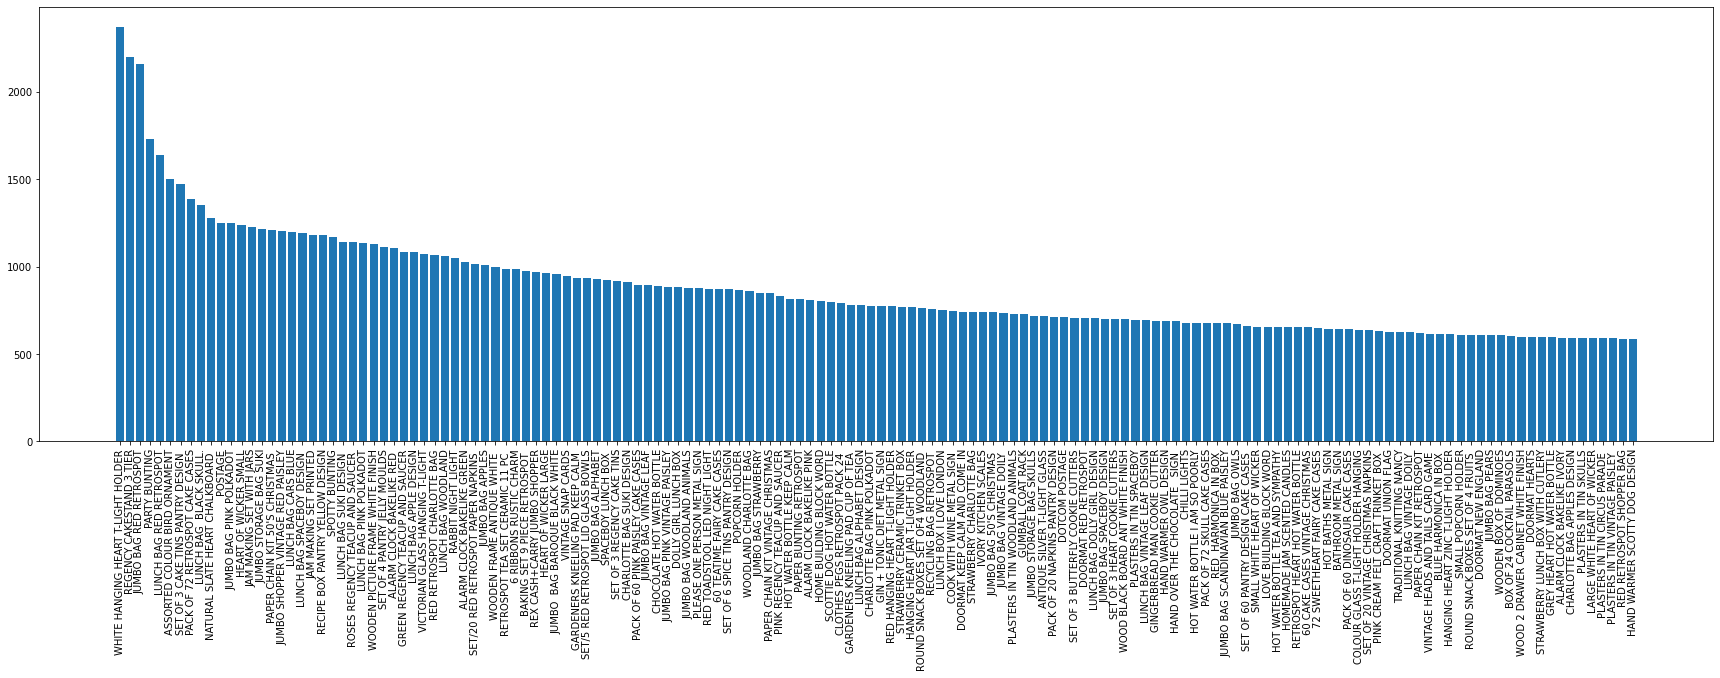

In [131]:
product_count = df['Description'].value_counts()
fig = plt.figure(figsize=(30,8))
plt.bar(product_count.index[:150], product_count.values[:150]) #graficando los primeros 150
plt.xticks(rotation = 90)
plt.show()

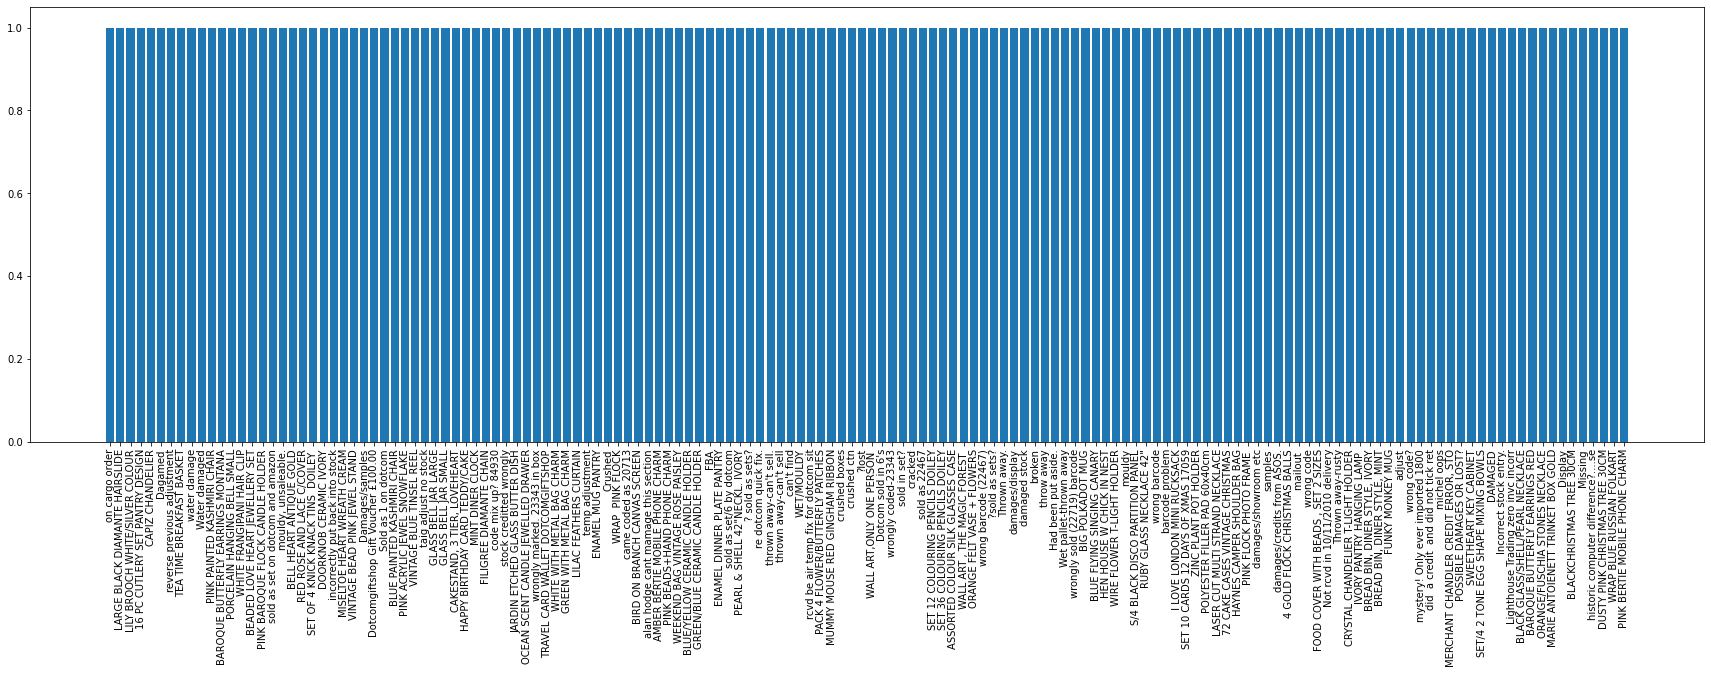

In [132]:
fig = plt.figure(figsize=(30,8))
plt.bar(product_count.index[-150:], product_count.values[-150:]) #graficando los ultimos 150
plt.xticks(rotation = 90)
plt.show()

Podemos ver que los ultimos 150 productos tienen 1 venta en total, por cuestiones practicas estos seran eliminados del set de datos a visualizar.

In [133]:
# ¿En que categoria se encuentra el 60% de los datos del dataset?
products = pd.DataFrame(product_count)
products.columns = ['count'] #cambiar el nombre de la columna a count
products.head()
total_data = len(df) #numero de registros en el dataset
products['%'] = (products['count'] / total_data)*100 #saco el porcentaje de datos que tiene cada categoria 
products['agg'] = products['%'].cumsum() #saco la suma acumulada

Saque la suma acumulada para saber de una manera mas sencilla en que producto se encuentra el 60% de mis datos.

In [134]:
products[products['agg'] >= 60]

,count,%,agg
CITRONELLA CANDLE GARDEN POT,233,0.042996,60.023546
MINI WOODEN HAPPY BIRTHDAY GARLAND,232,0.042812,60.066358
RED METAL BEACH SPADE,232,0.042812,60.109170
DECORATIVE WICKER HEART MEDIUM,232,0.042812,60.151981
FANCY FONTS BIRTHDAY WRAP,232,0.042812,60.194793
...,...,...,...
Missing,1,0.000185,99.730951
historic computer difference?....se,1,0.000185,99.731136
DUSTY PINK CHRISTMAS TREE 30CM,1,0.000185,99.731320
WRAP BLUE RUSSIAN FOLKART,1,0.000185,99.731505


Aproximadamente en el producto CITRONELLA CANDLE GARDEN POT se encuentra el 60% de mis datos.

In [135]:
categorias_sesenta = products[products['agg'] < 60].count() #694 categorias de productos representan el 60% de mis datos
categorias_sesenta

count    694
%        694
agg      694
dtype: int64

In [136]:
categorias_total = len(products.index.values)
categorias_total

4223

En total hay 4223 productos de los cuales 694 representan el 60% de las ventas.

Los 694 productos mencionados son los que seran adaptados para unir con los demas conjuntos de datos. 

A tener en cuenta: Se debe de elaborar y agregar una columna de categoria de productos.

### carsWorldWide

Suposiciones:
- Se va a suponer que cada registro que aparece en el set de datos es una venta unica de x articulo.

In [137]:
FILE_PATH = './datasets/carsWorldWide.csv'
df_cars = pd.read_csv(FILE_PATH, encoding = 'unicode_escape')

In [138]:
print(df_cars.columns)
df_cars.head(3)

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium


In [139]:
df_cars['PRODUCTLINE'].unique() #categorias de productos

array(['Motorcycles', 'Classic Cars', 'Trucks and Buses', 'Vintage Cars',
       'Planes', 'Ships', 'Trains'], dtype=object)

A tener en cuenta: Se debe de elaborar y agregar una columna de nombre de producto.

### retailWorldWide

In [140]:
FILE_PATH = './datasets/retailWorldWide.csv'
df_retail = pd.read_csv(FILE_PATH)

In [141]:
df_retail.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62


In [142]:
df_retail[df_retail['Sales'] == min(df_retail['Sales'])] #Analizando la minima venta

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
4101,4102,US-2018-102288,19/06/2018,23/06/2018,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,United States,Houston,Texas,77095.0,Central,OFF-AP-10002906,Office Supplies,Appliances,Hoover Replacement Belt for Commercial Guardsm...,0.444


In [143]:
df_retail[df_retail['Sales'] == max(df_retail['Sales'])] #Analizando la maxima venta

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
2697,2698,CA-2015-145317,18/03/2015,23/03/2015,Standard Class,SM-20320,Sean Miller,Home Office,United States,Jacksonville,Florida,32216.0,South,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.48


A tener en cuenta: Se debe de elaborar y agregar una columna de precio por unidad y cantidad de unidades vendidas.

## Estructurando la informacion

Luego del analisis previo de los sets de datos de los que disponemos, tendremos que moldear los mismos para que cada uno de ellos cumpla una estructura igual (ver Tabla 1) y asi poderlos juntar en uno solo. Lo mencionado es lo que se hara en esta seccion.

Tabla 1. *Estructura que debera de cumplir cada uno de los sets de datos*

| id | categoria | nombre_producto | cantidad_unidades | precio_x_unidad | fecha_pedido | fecha_llegada_pedido | venta_total | pais | ciudad |
|----|-----------|-----------------|-------------------|-----------------|--------------|----------------------|-------------|------|--------|
| 01 |accesorios |reloj inteligente samsung | 1 | 100 | 22/08/2022 | 22/09/2022 | 100 | Estados Unidos | Miami


### ukStore estructura

In [144]:
uk_store = pd.DataFrame.copy(df)
uk_store.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [145]:
null_descriptions = len(df['Description'][df['Description'].isna()]) #numero de descripciones nulas
null_percentage = (null_descriptions / len(uk_store)) * 100 #porcentaje de descripciones nulas
not_null_descriptions = len(uk_store) - null_descriptions #numero de descripciones no nulas
completeness_index = (not_null_descriptions / len(uk_store)) * 100 #indice de completitud de la columna descripcion
print(f"""Hay un total de {null_descriptions} descripciones nulas, las cuales me representan un {round(null_percentage,2)} % del total de datos.
        \nY un total de {not_null_descriptions} descripciones no nulas. \nSe tiene un indice de completitud del {round(completeness_index,2)}""")

Hay un total de 1454 descripciones nulas, las cuales me representan un 0.27 % del total de datos.
        
Y un total de 540455 descripciones no nulas. 
Se tiene un indice de completitud del 99.73


Podemos ver que los datos nulos no son la mayoria del set de datos, por lo que, procederemos a eliminiarlos.

In [146]:
uk_store.dropna(inplace = True) #elimino filas con datos nulos

In [147]:
#necesito hallar categorias de productos
products = uk_store['Description'].values
str_products = [str(product).rstrip() for product in products] #convierto todo a string y quito espacios al ppio y final de la cadena
words = [word.split(" ") for word in str_products] 
words = list(flatten(words)) #aplano la lista anterior

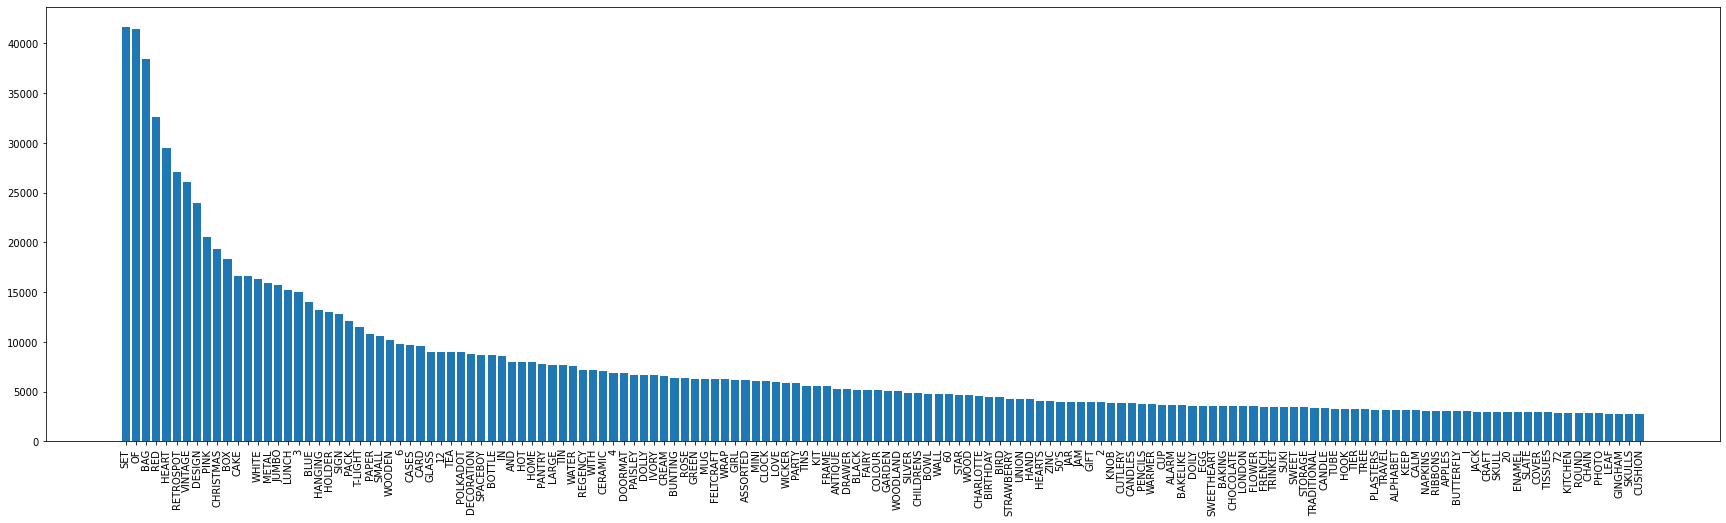

In [148]:
categories = pd.Series(words).value_counts() #convierto a series y cuento los valores repetidos para hallar categorias
fig = plt.figure(figsize=(30,8))
plt.bar(categories.index[:150], categories.values[:150]) #graficando los ultimos 150
plt.xticks(rotation = 90)
plt.show()

In [149]:
uk_store[uk_store['Description'].str.contains(r"\bDECORATION\b", regex = True)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
188,536388,22318,FIVE HEART HANGING DECORATION,6,12/1/2010 9:59,2.95,16250.0,United Kingdom
219,536390,20668,DISCO BALL CHRISTMAS DECORATION,288,12/1/2010 10:19,0.10,17511.0,United Kingdom
251,536392,22338,STAR DECORATION PAINTED ZINC,24,12/1/2010 10:29,0.65,13705.0,United Kingdom
457,536408,22219,LOVEBIRD HANGING DECORATION WHITE,12,12/1/2010 11:41,0.85,14307.0,United Kingdom
513,536409,20668,DISCO BALL CHRISTMAS DECORATION,24,12/1/2010 11:45,0.12,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541578,581502,22155,STAR DECORATION RUSTIC,6,12/9/2011 10:51,0.42,15910.0,United Kingdom
541580,581502,22573,STAR WOODEN CHRISTMAS DECORATION,8,12/9/2011 10:51,0.85,15910.0,United Kingdom
541585,581502,22153,ANGEL DECORATION STARS ON DRESS,1,12/9/2011 10:51,0.42,15910.0,United Kingdom
541737,581571,22227,HANGING HEART MIRROR DECORATION,10,12/9/2011 12:00,0.65,15311.0,United Kingdom


In [150]:
def set_category(row):
    if "SET" in row:
        return 'Furnishing'
    elif "BAG" in row:
        return "Accessories"
    elif "PAPER" in row:
        return "Paper"
    elif "HANGING" in row:
        return 'Furnishing'
    elif "CAKE" in row:
        return 'Appliances'
    elif 'HEART' in row:
        return 'Furnishing'
    elif "VINTAGE" in row:
        return "Art"
    elif "DECORATION" in row:
        return "Furnishing"
    else:
        return np.nan

In [151]:
uk_store['category'] = uk_store['Description'].apply(set_category) #sacamos categorias a una parte de los datos
uk_store.dropna(inplace = True) #eliminamos los que quedaron sin categoria

In [152]:
number_of_dates = len(uk_store)
uk_store['OrderDate'] = generate_rand_dates(number = number_of_dates) #genero fechas de pedido
uk_store['ArrivalDate'] = generate_rand_dates(number = number_of_dates, start_date=uk_store['OrderDate'].values) #genero fechas de llegada del producto

In [153]:
uk_store.drop(['InvoiceNo', 'StockCode','InvoiceDate','CustomerID'], axis = 1, inplace = True) #elimino columnas que no sirven

In [154]:
uk_store.columns = ['ProductName', 'ProductQuantity', 'UnitPrice', 'Country', 'Category', 'OrderDate', 'ArrivalDate'] #renombro las columnas
uk_store['ProductQuantity'] = abs(uk_store['ProductQuantity']) #quito las cantidades negativas de productos enviados 
uk_store['Sales'] = uk_store['ProductQuantity'] * uk_store['UnitPrice']

In [155]:
uk_store.sample(5)

,ProductName,ProductQuantity,UnitPrice,Country,Category,OrderDate,ArrivalDate,Sales
142752,SET OF 5 PANCAKE DAY MAGNETS,12,2.08,United Kingdom,Furnishing,2019-08-27 02:38:09,2021-06-21 06:42:20,24.96
304074,STRAWBERRY FAIRY CAKE TEAPOT,8,4.95,EIRE,Appliances,2021-10-20 14:38:06,2021-11-10 10:40:46,39.60
336917,REINDEER HEART DECORATION GOLD,36,0.83,United Kingdom,Furnishing,2020-10-14 21:11:24,2021-11-10 06:26:55,29.88
458508,JUMBO BAG 50'S CHRISTMAS,4,2.08,United Kingdom,Accessories,2020-04-01 21:26:39,2020-10-13 20:52:14,8.32
391353,SET OF 4 KNICK KNACK TINS DOILY,6,4.15,United Kingdom,Furnishing,2018-12-16 01:30:23,2020-03-20 22:59:33,24.90


Ya que se tienen categorias de productos, fecha del pedido y fecha de llegada del mismo se procedera a sacar las ciudades de los paises.

In [218]:
posible_countries = ['USA', 'France', 'Norway', 'Australia', 'Finland', 'Austria', 'UK',
       'Spain', 'Sweden', 'Singapore', 'Canada', 'Japan', 'Italy',
       'Denmark', 'Belgium', 'Philippines', 'Germany', 'Switzerland',
       'Ireland'] 

rand_countries = [np.random.choice(posible_countries) for i in range(0, len(uk_store))]
uk_store['Country'] =  rand_countries

In [220]:
country_city = {
    'USA' : ['NYC', 'Pasadena', 'San Francisco','Burlingame','Newark', 'Bridgewater',
            'Cambridge', 'Allentown', 'New Bedford', 'Philadelphia', 'Burbank',
            'New Haven', 'San Rafael', 'Nashua', 'Brickhaven', 'White Plains',
            'Los Angeles', 'San Diego' ,'Boston', 'San Jose' ,'Glendale' ,'Brisbane',
            'Las Vegas'], 
    'France' : ['Reims', 'Paris', 'Lille', 'Nantes', 'Lyon', 'Versailles', 'Toulouse',
                'Marseille','Strasbourg'], 
    'Norway' : ['Bergen' ,'Stavern', 'Oslo'],
    'Australia' : ['Melbourne', 'Chatswood', 'South Brisbane' ,'North Sydney' ,'Glen Waverly'],
    'Finland' : ['Helsinki', 'Oulu', 'Espoo'],
    'Austria' : ['Salzburg', 'Graz'],
    'UK' : ['Liverpool' ,'London' ,'Cowes' ,'Manchester'],
    'Spain' : ['Madrid' ,'Barcelona' ,'Sevilla'], 
    'Sweden' : ['Lule', 'Boras'], 
    'Singapore' : ['Singapore'],
    'Canada' : ['Vancouver' ,'Montreal' ,'Tsawassen'],
    'Japan' : ['Minato-ku', 'Osaka'],
    'Italy' : ['Torino' ,'Reggio Emilia' ,'Bergamo'],
    'Denmark' : ['Kobenhavn' ,'Aaarhus'],
    'Belgium' : ['Bruxelles' ,'Charleroi'] ,
    'Philippines' : ['Makati City'],
    'Germany' : ['Koln', 'Frankfurt', 'Munich'],
    'Switzerland' : ['Gensve'],
    'Ireland' : ['Dublin']
}

uk_store['City'] = uk_store['Country'].apply(get_product_name, category_product = country_city)

In [233]:
uk_store.sample(5)

,ProductName,ProductQuantity,UnitPrice,Country,Category,OrderDate,ArrivalDate,Sales,City
353349,PAPER CHAIN KIT RETROSPOT,12,2.95,Singapore,Paper,2016-01-12 12:54:05,2016-05-30 03:12:34,35.40,Singapore
429757,LUNCH BAG SPACEBOY DESIGN,2,4.13,Canada,Accessories,2018-09-28 03:18:44,2019-06-02 13:57:35,8.26,Vancouver
428132,CHRISTMAS TREE STAR DECORATION,5,0.42,Switzerland,Furnishing,2017-04-01 15:19:54,2021-10-06 07:25:00,2.10,Gensve
419830,PACK OF 72 SKULL CAKE CASES,24,0.55,Singapore,Appliances,2021-10-07 12:02:42,2021-12-05 11:24:44,13.20,Singapore
195305,LUNCH BAG ALPHABET DESIGN,30,1.65,USA,Accessories,2017-08-07 10:12:38,2020-01-28 10:43:44,49.50,Burlingame


### retailWorldWide estructura

In [157]:
df_retail.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96


In [158]:
df_retail.drop(columns = ['Row ID', 'Order ID', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'State', 'Postal Code', 'Region', 'Product ID', 'Sub-Category']
               , inplace = True) #elimino columnas que no necesito de df

In [159]:
df_retail.columns = ['OrderDate', 'ArrivalDate', 'Country', 'City', 'Category', 'ProductName', 'Sales']
df_retail.head(1)

,OrderDate,ArrivalDate,Country,City,Category,ProductName,Sales
0,08/11/2017,11/11/2017,United States,Henderson,Furniture,Bush Somerset Collection Bookcase,261.96


In [235]:
df_retail['ProductQuantity'] = 1 #añadir columna de cantidad pedida igual 1
df_retail['UnitPrice'] = df_retail['Sales'] #el precio de la unidad es el precio de la venta
df_retail['Country'] = "USA" #Cambio United States por USA para tener misma estructura en todos los sets de datos

In [239]:
df_retail['OrderDate'] = generate_rand_dates(len(df_retail['OrderDate'])) #genero fecha de pedido
df_retail['ArrivalDate'] = generate_rand_dates(len(df_retail['ArrivalDate']), df_retail['OrderDate'].values) #genero fecha entrega de pedido

In [240]:
df_retail.sample(5)

,OrderDate,ArrivalDate,Country,City,Category,ProductName,Sales,ProductQuantity,UnitPrice
3077,2017-12-08 16:02:35,2019-07-27 02:38:40,USA,Dallas,Furniture,HON 5400 Series Task Chairs for Big and Tall,981.372,1,981.372
8679,2018-03-25 05:34:33,2020-09-30 14:24:49,USA,Houston,Technology,Logitech MX Performance Wireless Mouse,159.560,1,159.560
2282,2018-04-23 08:19:30,2018-06-21 20:43:37,USA,Middletown,Office Supplies,"Adams Phone Message Book, 200 Message Capacity...",48.160,1,48.160
7971,2020-07-25 01:55:20,2021-06-09 11:06:56,USA,Philadelphia,Technology,SanDisk Ultra 16 GB MicroSDHC Class 10 Memory ...,31.176,1,31.176
339,2019-01-01 06:33:46,2019-09-20 19:41:34,USA,Layton,Office Supplies,"OIC Binder Clips, Mini, 1/4"" Capacity, Black",4.960,1,4.960


### carsWorldWide estructura

In [161]:
df_cars.sample(1)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
2568,10198,42,100.0,1,4774.56,11/27/2003 0:00,Shipped,4,11,2003,...,15 McCallum Street - NatWest Center #13-03,NaN,Makati City,NaN,1227 MM,Philippines,Japan,Cruz,Arnold,Medium


In [162]:
drop_columns = df_cars.columns.values
drop_columns = np.delete(drop_columns, [1, 2, 4, 5, 10, 17, 20]) #quito los valores que no quiero eliminar
df_cars.drop(columns = drop_columns, inplace = True)

In [168]:
df_cars.columns = ['ProductQuantity', 'UnitPrice', 'Sales', 'OrderDate', 'Category', 'City', 'Country'] #renombro columnas del df
dates_num = len(df_cars['OrderDate'])
df_cars['OrderDate'] = generate_rand_dates(dates_num) #genero fechas de pedido
df_cars['ArrivalDate'] = generate_rand_dates(dates_num,df_cars['OrderDate'].values) #genero fechas de llegada de pedido

In [169]:
df_cars.sample(1)

,ProductQuantity,UnitPrice,Sales,OrderDate,Category,City,Country,ArrivalDate
2821,34,62.24,2116.16,2021-04-02 20:01:32,Ships,Toulouse,France,2021-09-23 05:47:46


In [177]:
products_dict = {
    'Motorcycles' : ['Bajaj Pulsar Ns 200', 'Honda Dio Dlx', 'Yamaha Sz15rr', 'Honda Eco Deluxe Es', 'Bmw R 1200 Gs'],
    'Classic Cars' : ['Nissan X-trail 2.2 S Clasic 4x4', 'Renault Megane 1.6 L Clasico', 
                      'Volkswagen Jetta Trendline Clasico 2000cc At Aa', 'Ford F-100 Ranger Lariat', 'Ford Ecosport 2.0 L 4x2'],
    'Trucks and Buses' : ['Chevrolet Frr 2014', 'Bus Frr Marcopolo', 'Autobuses Buses Mercedes Benz', 
                          'Autobus Volvo 420 Doblepiso', 'Mercedes Benz O 5oo 1836'],
    'Vintage Cars' : ['Porsche 911', 'Volkwagen Beetle', '1957 Corvette', '1968-1969 Dodge Charger', '1937 Packard'],
    'Planes' : ['Emirates B-777', 'avianca B747', 'gemini western global', 'herpa eurowings A320', 'herpa alaska 737-900'],
    'Ships' : ['36 open deck series', '392 profish series', '44 open deck series', '44 cuddy cabin series', '30 cuddy cabin series'],
    'Trains' : ['fleischmann 391101', 'usatc 1/87 H0', 'siku 1646001', 'Mehano T111', 'Zestaw Startowy'],
}

df_cars['ProductName'] = df_cars['Category'].apply(get_product_name, category_product = products_dict)

In [178]:
df_cars.sample(5)

,ProductQuantity,UnitPrice,Sales,OrderDate,Category,City,Country,ArrivalDate,ProductName
1921,37,100.00,3724.42,2019-07-06 07:04:56,Classic Cars,Manchester,UK,2021-11-07 19:20:46,Renault Megane 1.6 L Clasico
2518,40,80.55,3222.00,2017-06-30 08:39:31,Ships,Lyon,France,2017-09-24 18:28:20,30 cuddy cabin series
1751,22,69.20,1522.40,2018-04-10 21:55:06,Planes,London,UK,2020-09-11 13:38:19,herpa eurowings A320
1,34,81.35,2765.90,2018-03-02 23:13:56,Motorcycles,Reims,France,2021-06-25 04:55:12,Honda Eco Deluxe Es
1175,46,100.00,7343.90,2019-10-23 05:04:57,Classic Cars,San Diego,USA,2020-07-08 09:36:17,Renault Megane 1.6 L Clasico


## Armando los sets de datos finales

Una vez los datos se encuentran estructurados como requerimos es momento de armar los sets de datos finales.

In [241]:
db_retail = pd.concat([uk_store, df_retail], axis = 0)

,ProductName,ProductQuantity,UnitPrice,Country,Category,OrderDate,ArrivalDate,Sales,City
134464,LAVENDER SCENTED FABRIC HEART,10,1.25,Spain,Furnishing,2017-05-07 22:03:54,2020-10-18 20:15:08,12.50,Barcelona
213844,HEART T-LIGHT HOLDER WILLIE WINKIE,6,1.65,Japan,Furnishing,2019-04-09 10:46:05,2019-08-26 21:34:37,9.90,Minato-ku
483289,CHRISTMAS HANGING STAR WITH BELL,4,0.39,Switzerland,Furnishing,2016-09-24 02:07:38,2019-02-19 12:07:47,1.56,Gensve
510243,LUNCH BAG WOODLAND,10,1.65,Philippines,Accessories,2020-05-01 06:46:36,2021-09-26 21:05:38,16.50,Makati City
304079,PACK OF 72 RETROSPOT CAKE CASES,24,0.55,USA,Appliances,2019-08-27 23:39:00,2020-11-13 11:15:54,13.20,San Diego


In [242]:
#coloco identificador unico a las filas del df
db_retail['ID'] = [i for i in range(0,len(db_retail))]
df_cars['ID'] = [i for i in range(0,len(df_cars))]

In [243]:
db_retail.sample(5)

,ProductName,ProductQuantity,UnitPrice,Country,Category,OrderDate,ArrivalDate,Sales,City,ID
419821,HANGING HEART WITH BELL,48,0.39,Japan,Furnishing,2019-06-07 21:30:35,2020-04-24 06:05:33,18.72,Osaka,127634
343667,VINTAGE 2 METER FOLDING RULER,1,1.65,Ireland,Art,2020-10-15 23:44:22,2021-08-01 19:48:05,1.65,Dublin,101533
335331,JUMBO BAG 50'S CHRISTMAS,30,2.08,Australia,Accessories,2019-11-08 12:01:34,2021-11-13 12:36:11,62.40,North Sydney,98595
233450,HEART OF WICKER SMALL,12,1.65,Switzerland,Furnishing,2016-04-25 23:17:03,2018-08-21 11:57:30,19.80,Gensve,66286
340728,VINTAGE SNAP CARDS,1,0.85,Switzerland,Art,2016-11-17 06:23:31,2020-10-19 04:08:16,0.85,Gensve,100611


In [244]:
df_cars.sample(5)

,ProductQuantity,UnitPrice,Sales,OrderDate,Category,City,Country,ArrivalDate,ProductName,ID
2117,43,100.00,10039.60,2020-03-19 01:23:12,Planes,Nantes,France,2021-08-08 17:54:11,Emirates B-777,2117
2367,47,43.64,2051.08,2020-01-25 20:00:09,Vintage Cars,White Plains,USA,2020-07-08 05:20:10,1937 Packard,2367
2211,37,41.03,1518.11,2019-07-14 20:55:49,Motorcycles,Cambridge,USA,2021-06-08 06:10:51,Honda Dio Dlx,2211
1576,32,87.60,2803.20,2016-04-22 20:40:47,Motorcycles,San Jose,USA,2017-09-29 20:43:48,Honda Eco Deluxe Es,1576
1566,43,83.03,3570.29,2021-05-26 22:26:26,Motorcycles,Paris,France,2021-12-08 07:01:28,Yamaha Sz15rr,1566


In [249]:
#Paso a csv los sets de datos
db_retail.to_excel("./BI_datasets/db_retail.xlsx",index = False, sheet_name = 'Retail Sales')
df_cars.to_excel("./BI_datasets/db_cars.xlsx", index = False, sheet_name='Automobile Sales')